# Does your dorm matter for your well-being?

We build models to predict:
1. Spring well-being from fall well-being
1. Spring well-being from fall well-being and demographic items (age, family income, family education, race, gender)
1. Spring well-being from fall well-being and demographic items and fixed effects per dorm

We are interested in the gain in variance explained from step 2 to step 3. Because we get additional degrees of freedom by including more columns, we expect this fit to increase even if the dorm is meaningless. To combat this, we use random shuffling to determine how likely this much additional fit would occur if dorms were truly irrelevant (by randomly shuffling dorm assignments 1000 times and computing the explained-variance-gain under each).

# Results:
- 43% of spring well-being can be explained by fall well-being along
- Another 4% can be explained by adding demographic variables. 10% can be explained by demographic variables alone (that is, without fall well-being).
- No futher variance can be explained by dorm-level fixed effects (r² gains are ns).

# Conclusion:
- Dorm does not matter.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configure" data-toc-modified-id="Configure-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configure</a></span></li><li><span><a href="#Import-and-load" data-toc-modified-id="Import-and-load-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import and load</a></span></li><li><span><a href="#Quick-summary-of-whole-dorm-well-beings" data-toc-modified-id="Quick-summary-of-whole-dorm-well-beings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quick summary of whole-dorm well-beings</a></span></li><li><span><a href="#Base-model,-minimal-predictors" data-toc-modified-id="Base-model,-minimal-predictors-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Base model, minimal predictors</a></span></li><li><span><a href="#Model-with-demographic-covariates" data-toc-modified-id="Model-with-demographic-covariates-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model with demographic covariates</a></span></li></ul></div>

## Configure

In [1]:
INPUT_DATAFILE = '../data/2018-2019/postprocessed/final_for_analysis_R.csv'
INCLUDE_FALL_WB_AS_PREDICTOR = True
INCLUDE_DEMOS_AS_PREDICTOR = True
# DV = 'Wellbeing_fall'
DV = 'Wellbeing_spring'

if INCLUDE_FALL_WB_AS_PREDICTOR:
    assert DV != 'Wellbeing_fall'

## Import and load

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2020-02-05 10:37:43 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


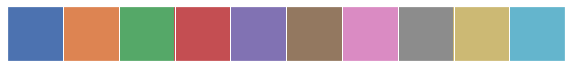

In [3]:
import datetime as dt
import os
import random
import re
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

####################################################
# END Boilerplate
####################################################

In [4]:
from sklearn import linear_model, dummy

In [5]:
df = pd.read_csv(INPUT_DATAFILE, index_col='PID')
print(df.shape)
df = df[[
    'NID', 'Age', 'ParentEducationMax',
    'FinclAid', 'FmlyIncome', 'Gender', 'Race',
    'Wellbeing_fall', 'Wellbeing_spring']]
df.dropna(inplace=True)
print(df.shape)
df.head()

(204, 51)
(178, 9)


,NID,Age,ParentEducationMax,FinclAid,FmlyIncome,Gender,Race,Wellbeing_fall,Wellbeing_spring
PID,,,,,,,,,
vgxlTMkQs5,7.0,18.0,4.0,0.0,87500.0,M,white,-2.063548,-0.765354
RdS4vMvQjo,9.0,18.0,4.0,1.0,125000.0,M,white,0.919656,0.665411
n08loMfJH7,4.0,18.0,4.0,0.0,200000.0,F,east_asian,0.653420,0.486565
8rsekwqjFy,5.0,18.0,2.5,1.0,125000.0,M,south_asian,0.698392,-0.049972
FjTWohEryS,13.0,18.0,4.0,1.0,45000.0,F,east_asian,0.042904,-0.139394


In [6]:
df = pd.get_dummies(df)
df.head()

,NID,Age,ParentEducationMax,FinclAid,FmlyIncome,Wellbeing_fall,Wellbeing_spring,Gender_F,Gender_M,Gender_other,Race_black,Race_east_asian,Race_hispanic,Race_other_or_mixed,Race_south_asian,Race_white
PID,,,,,,,,,,,,,,,,
vgxlTMkQs5,7.0,18.0,4.0,0.0,87500.0,-2.063548,-0.765354,0,1,0,0,0,0,0,0,1
RdS4vMvQjo,9.0,18.0,4.0,1.0,125000.0,0.919656,0.665411,0,1,0,0,0,0,0,0,1
n08loMfJH7,4.0,18.0,4.0,0.0,200000.0,0.653420,0.486565,1,0,0,0,1,0,0,0,0
8rsekwqjFy,5.0,18.0,2.5,1.0,125000.0,0.698392,-0.049972,0,1,0,0,0,0,0,1,0
FjTWohEryS,13.0,18.0,4.0,1.0,45000.0,0.042904,-0.139394,1,0,0,0,1,0,0,0,0


## Quick summary of whole-dorm well-beings

In [7]:
df.groupby('NID').mean()[['Wellbeing_fall', 'Wellbeing_spring']]

,Wellbeing_fall,Wellbeing_spring
NID,,
1.0,0.074005,0.383385
2.0,0.053285,0.175715
4.0,-0.089503,0.080437
5.0,0.056079,0.045839
7.0,0.074833,0.276422
8.0,-0.165298,-0.497086
9.0,-0.224319,-0.354009
10.0,-0.196476,-0.288432
11.0,0.158682,0.167198


## Base model, minimal predictors

In [8]:
def fit_and_score(frame, ivs):
    X = frame[ivs].values
    y = frame[DV].values
    if ivs:
        model = linear_model.LinearRegression()
    else:
        model = dummy.DummyRegressor()
    model.fit(X, y)
    r2 = model.score(X, y)
    return model, r2

In [9]:
if INCLUDE_FALL_WB_AS_PREDICTOR:
    base_model, base_model_r2 = fit_and_score(df, ['Wellbeing_fall'])
    print("Score:", base_model_r2)
    print("Coefficients:", base_model.coef_)
else:
    base_model_r2 = 0
    print("Intercept-only model has an r² of 0 by definition")

Score: 0.43306325545047164
Coefficients: [0.67786317]


## Model with demographic covariates

In [10]:
df.columns

Index(['NID', 'Age', 'ParentEducationMax', 'FinclAid', 'FmlyIncome',
       'Wellbeing_fall', 'Wellbeing_spring', 'Gender_F', 'Gender_M',
       'Gender_other', 'Race_black', 'Race_east_asian', 'Race_hispanic',
       'Race_other_or_mixed', 'Race_south_asian', 'Race_white'],
      dtype='object')

In [11]:
ivs = ['Wellbeing_fall'] if INCLUDE_FALL_WB_AS_PREDICTOR else []

if INCLUDE_DEMOS_AS_PREDICTOR:
    demographic_cols = [
        'Age',
        'ParentEducationMax', 
        'FinclAid', 'FmlyIncome']
    for c in df.columns:
        if c.startswith('Race_') or c.startswith('Gender_'):
            demographic_cols.append(c)
    ivs.extend(demographic_cols)

    demo_model, demo_model_r2 = fit_and_score(df, ivs)
    print("Score (predicting %s):" % DV, demo_model_r2)
    print("Coefficients:")
    for k, v in list(zip(ivs, demo_model.coef_)):
        print(f'{v:.6f}  {k}')

Score (predicting Wellbeing_spring): 0.47137578402501784
Coefficients:
0.649146  Wellbeing_fall
-0.027582  Age
-0.002070  ParentEducationMax
-0.130016  FinclAid
0.000001  FmlyIncome
0.027859  Gender_F
0.181384  Gender_M
-0.209243  Gender_other
-0.036947  Race_black
0.003615  Race_east_asian
0.161126  Race_hispanic
-0.103809  Race_other_or_mixed
-0.236971  Race_south_asian
0.212987  Race_white


In [12]:
frame = pd.get_dummies(df, columns=['NID'], drop_first=True)
frame.head()

,Age,ParentEducationMax,FinclAid,FmlyIncome,Wellbeing_fall,Wellbeing_spring,Gender_F,Gender_M,Gender_other,Race_black,Race_east_asian,Race_hispanic,Race_other_or_mixed,Race_south_asian,Race_white,NID_2.0,NID_4.0,NID_5.0,NID_7.0,NID_8.0,NID_9.0,NID_10.0,NID_11.0,NID_13.0,NID_15.0
PID,,,,,,,,,,,,,,,,,,,,,,,,,
vgxlTMkQs5,18.0,4.0,0.0,87500.0,-2.063548,-0.765354,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
RdS4vMvQjo,18.0,4.0,1.0,125000.0,0.919656,0.665411,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
n08loMfJH7,18.0,4.0,0.0,200000.0,0.653420,0.486565,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8rsekwqjFy,18.0,2.5,1.0,125000.0,0.698392,-0.049972,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
FjTWohEryS,18.0,4.0,1.0,45000.0,0.042904,-0.139394,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
for c in frame.columns:
    if c.startswith('NID'):
        ivs.append(c)

In [14]:
dorm_model, dorm_model_r2 = fit_and_score(frame, ivs)
print("Score (predicting %s):" % DV, dorm_model_r2)
print("Coefficients:")
for k, v in list(zip(ivs, dorm_model.coef_)):
    print(f'{v:.6f}  {k}')

Score (predicting Wellbeing_spring): 0.5132549032430171
Coefficients:
0.623390  Wellbeing_fall
0.079461  Age
-0.001287  ParentEducationMax
-0.121961  FinclAid
0.000001  FmlyIncome
-0.021262  Gender_F
0.126357  Gender_M
-0.105095  Gender_other
-0.040404  Race_black
0.054517  Race_east_asian
0.120484  Race_hispanic
-0.186421  Race_other_or_mixed
-0.077559  Race_south_asian
0.129383  Race_white
-0.216948  NID_2.0
-0.288489  NID_4.0
-0.387551  NID_5.0
-0.199065  NID_7.0
-0.816563  NID_8.0
-0.597773  NID_9.0
-0.472834  NID_10.0
-0.422939  NID_11.0
-0.830527  NID_13.0
-0.355973  NID_15.0


In [15]:
scores = []
for i in range(1000):
    shuffled = df.copy()
    shuffled['NID'] = shuffled['NID'].sample(frac=1.0).values
    shuffled = pd.get_dummies(shuffled, columns=['NID'], drop_first=True)
    tmp_model, tmp_model_r2 = fit_and_score(shuffled, ivs)
    scores.append(tmp_model_r2)

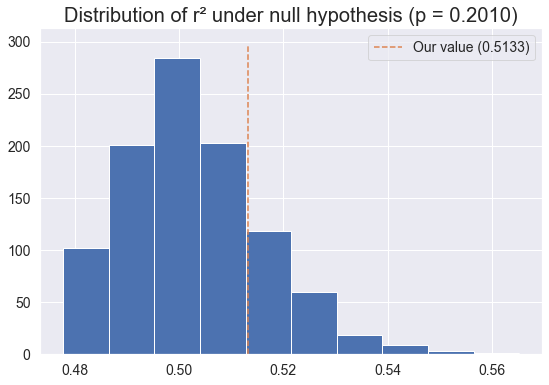

In [16]:
fig, ax = plt.subplots(1)
pd.Series(scores).hist(ax=ax)
ax.plot([dorm_model_r2, dorm_model_r2], ax.get_ylim(), linestyle='--', label='Our value (%.4f)' % dorm_model_r2)
p = np.mean([0 if s < dorm_model_r2 else 1 for s in scores ])
ax.set_title("Distribution of r² under null hypothesis (p = %.4f)" % p)
ax.legend()